## Demo 1. Detect Kiremt onset with ROMP

This demo shows examples of how to detect Kiremt onset using the ROMP tool package.  

the objective is to:
1. get to know the parameters in `config.in` that set the onset threshold
2. understand how these parameters affect the onset detection

<br>


#### Remember each time we want to change any part of the config file or region definition, we need to follow the two steps below to set `config.in` or `region_def.py` and install the package  
1. edit `params/config.in` and/or `params/region_def.py`
2. cd into your repo directory, then `pip install .`

<br>

#### Data preperation  

for easy demo purpose, make a folder namely `data/` in your repo directory, and copy the demo data downloaded form the google drive to the `data/` folder.   

the data files should be organized following the structure as  

data  
├── AIFS  
├── AIFS_ENS  
├── gencast  
├── CHIRPS_IMERG  

<br>

**in `config.in` carefully set ALL dir parameters as the actual path on your computer. Try not using relative path as a learner user**

<br>

In [1]:
# run this notebook in your work directory
# Note that for best practices, the work dir should be different from repo dir. here is a bad example but for easy demo purpose only. 
%cd ~/Code/project/ROMP

/Users/bodong/Code/project/ROMP


In [2]:
import momp.lib.loader as loader
get_cfg = loader.get_cfg
from pathlib import Path
from IPython.display import Image, display

<br>

#### The onset threshold parameters in ROMP include:  

 `wet_init` Rain threshold (mm) to identify the first potential wet day.

 `wet_threshold` Rainfall threshold (mm) used only if no spatial thresh_file is provided.

 `wet_spell` Minimum number of days the accumlated rainfall must stay above threshold (Wet Spell).

 `dry_spell` Maximum number of consecutive dry days allowed after onset.

 `dry_extent` Search window (days) after onset to check for dry spell. 

<br>

First, we use the ICPAC operational seasonal rainfall onset definition as an example, where the threshold on accumulated rainfall technique is used: any day with less than 1 mm/day  rainfall is considered a dry day, days with at least 1 mm/day  rainfall are considered wet days. The rainy season onset date is then defined as the first day of a wet spell if the total rainfall accumulation within 3 consecutive days exceeds 20 mm and there is no dry spell of 7 or more days within the next 21 days.  

the corresponding threshold settings in `config.in` are
```
wet_init = 1
wet_threshold = 20
wet_spell = 3
dry_spell = 7
dry_extent = 21
```

Let's follow the demo config `demo/et/config_et_prob.in` as a template to edit the `params/config.in`, set the threshold parameters...  
Once we set these parameters, save the config file, install the package, and import the onset_time_series diagnositic API from the ROMP as

In [3]:
import momp.app.onset_time_series as ots
otsa = ots.obs_onset_analysis
cfg = get_cfg()
print("dry_extent = ", cfg.dry_extent)

Configuration validated!
Configuration validated!
Configuration validated!
dry_extent =  21


<br>

we select year 2020, location 10N, 40E as an example to see when there is an onset  




--------------------------------------------------
Processing year 2020
onset time series figure saved to /Users/bodong/Code/project/ROMP/demo/et/figure/onset_time_series.png


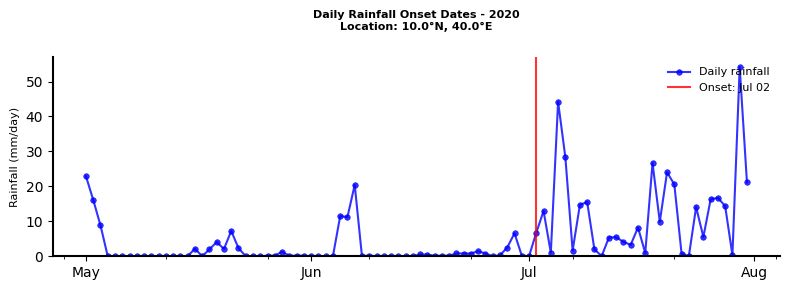

In [5]:
_ = otsa(year=2020, lat_select=10, lon_select=40, **vars(cfg))

<br>

The red line marks the onset of the rainy season, according to the onset definition.   

But we notice a few rainfall spikes in early June. Because of the dry spell constraint, that group of events are not considered as true onset.   

Now let's change the `dry_extent` to 0, which means to remove the dry spell constraint. run the diagnostic and see if an early onset is detected. 

dry_extent =  0

--------------------------------------------------
Processing year 2020
onset time series figure saved to /Users/bodong/Code/project/ROMP/demo/et/figure/onset_time_series.png


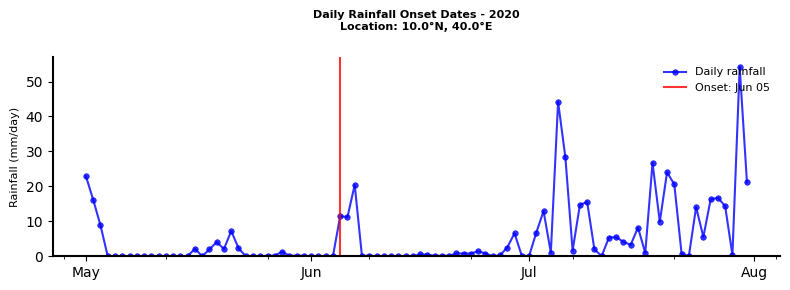

In [6]:
# import importlib
# importlib.reload(loader)
# importlib.reload(ots)
# otsa = ots.obs_onset_analysis
# get_cfg = loader.get_cfg
# cfg = get_cfg()
cfg.dry_extent = 0
print("dry_extent = ", cfg.dry_extent)
_ = otsa(year=2020, lat_select=10, lon_select=40, **vars(cfg))

<br>

now we see the detection catch the Jun 05 as the onset date, when the following dry spell is ignored.

<br>

#### Prompt: is there any location where the onset is not sensitive to the dry spell constraint? how do we assess that? 

<br>

### Spatial variability of onset day  

A spatial map of onset day can help us determine if the Kiremt onset if sensible for the study region by examining the spatial variability.     

Now let's leverage the ROMP's `onset_spatial` mapping tool to check onset day spatially for the year 2000. 
<br>


In [7]:
import momp.app.onset_spatial as osp
spatial_onset = osp.spatial_onset

Loading observational rainfall data...
Detecting observed onset...
Detected resolution: 0.2 degrees


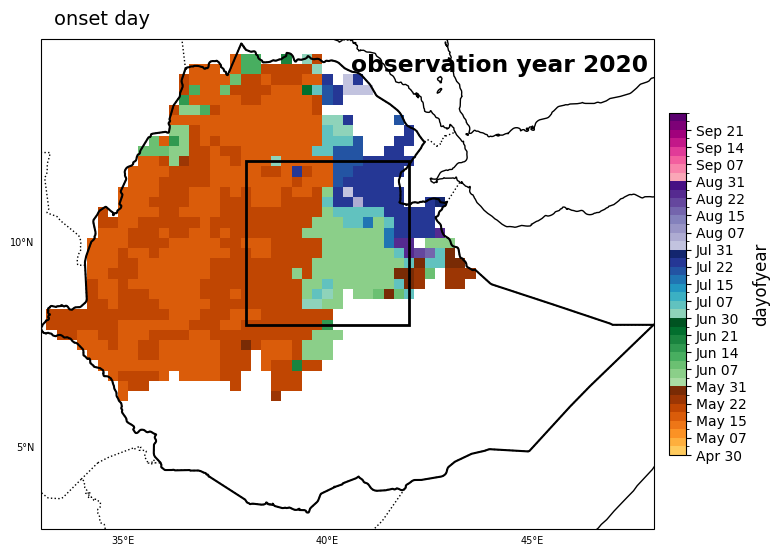

In [8]:
cfg.region = 'Ethiopia'
_ = spatial_onset(2020, **vars(cfg))

<br>

#### Prompt: Is the spatial advancement of onset sensible? can we identify locations that are too sensitive to the onset threshold? does year 2000 has about normal Kiremt onset? 


<br>

We can make use of the ROMP's climatological onset functionality to visually find out if year 2020 has any extreme onset event 

In [7]:
!python -m momp.graphics.onset_map --region Ethiopia

package base dir /Users/bodong/Code/project/ROMP/momp
work_dir =  /Users/bodong/Code/benchmarking/test_romp_project
pkg_dir =  /Users/bodong/Code/benchmarking/momp
ref_model_dir =  /Users/bodong/Code/project/ROMP/data/CHIRPS_IMERG
out_dir =  /Users/bodong/Code/project/ROMP/demo/et/output
out_fig =  /Users/bodong/Code/project/ROMP/demo/et/figure
obs_dir =  /Users/bodong/Code/project/ROMP/data/CHIRPS_IMERG
thresh_file =  None
shpfile_dir =  None
nc_mask =  /Users/bodong/Code/project/ROMP/demo/data/jjas_seasonal_mask_0p25.nc
Configuration validated!
Configuration validated!
processing model onset evaluation for climatology_1-15

 case.file_pattern =  {}.nc

 setting.ref_model_file_pattern =  {}.nc

 case_cfg_ref.file_pattern  =  {}.nc

  {'case_name': 'climatology_1-15', 'model': 'climatology', 'model_var': 'RAINFALL', 'model_dir': PosixPath('/Users/bodong/Code/project/ROMP/data/CHIRPS_IMERG'), 'obs': 'CHIRPS_IMERG', 'obs_var': 'RAINFALL', 'ref_model': 'climatology', 'ref_model_var': 'RAI

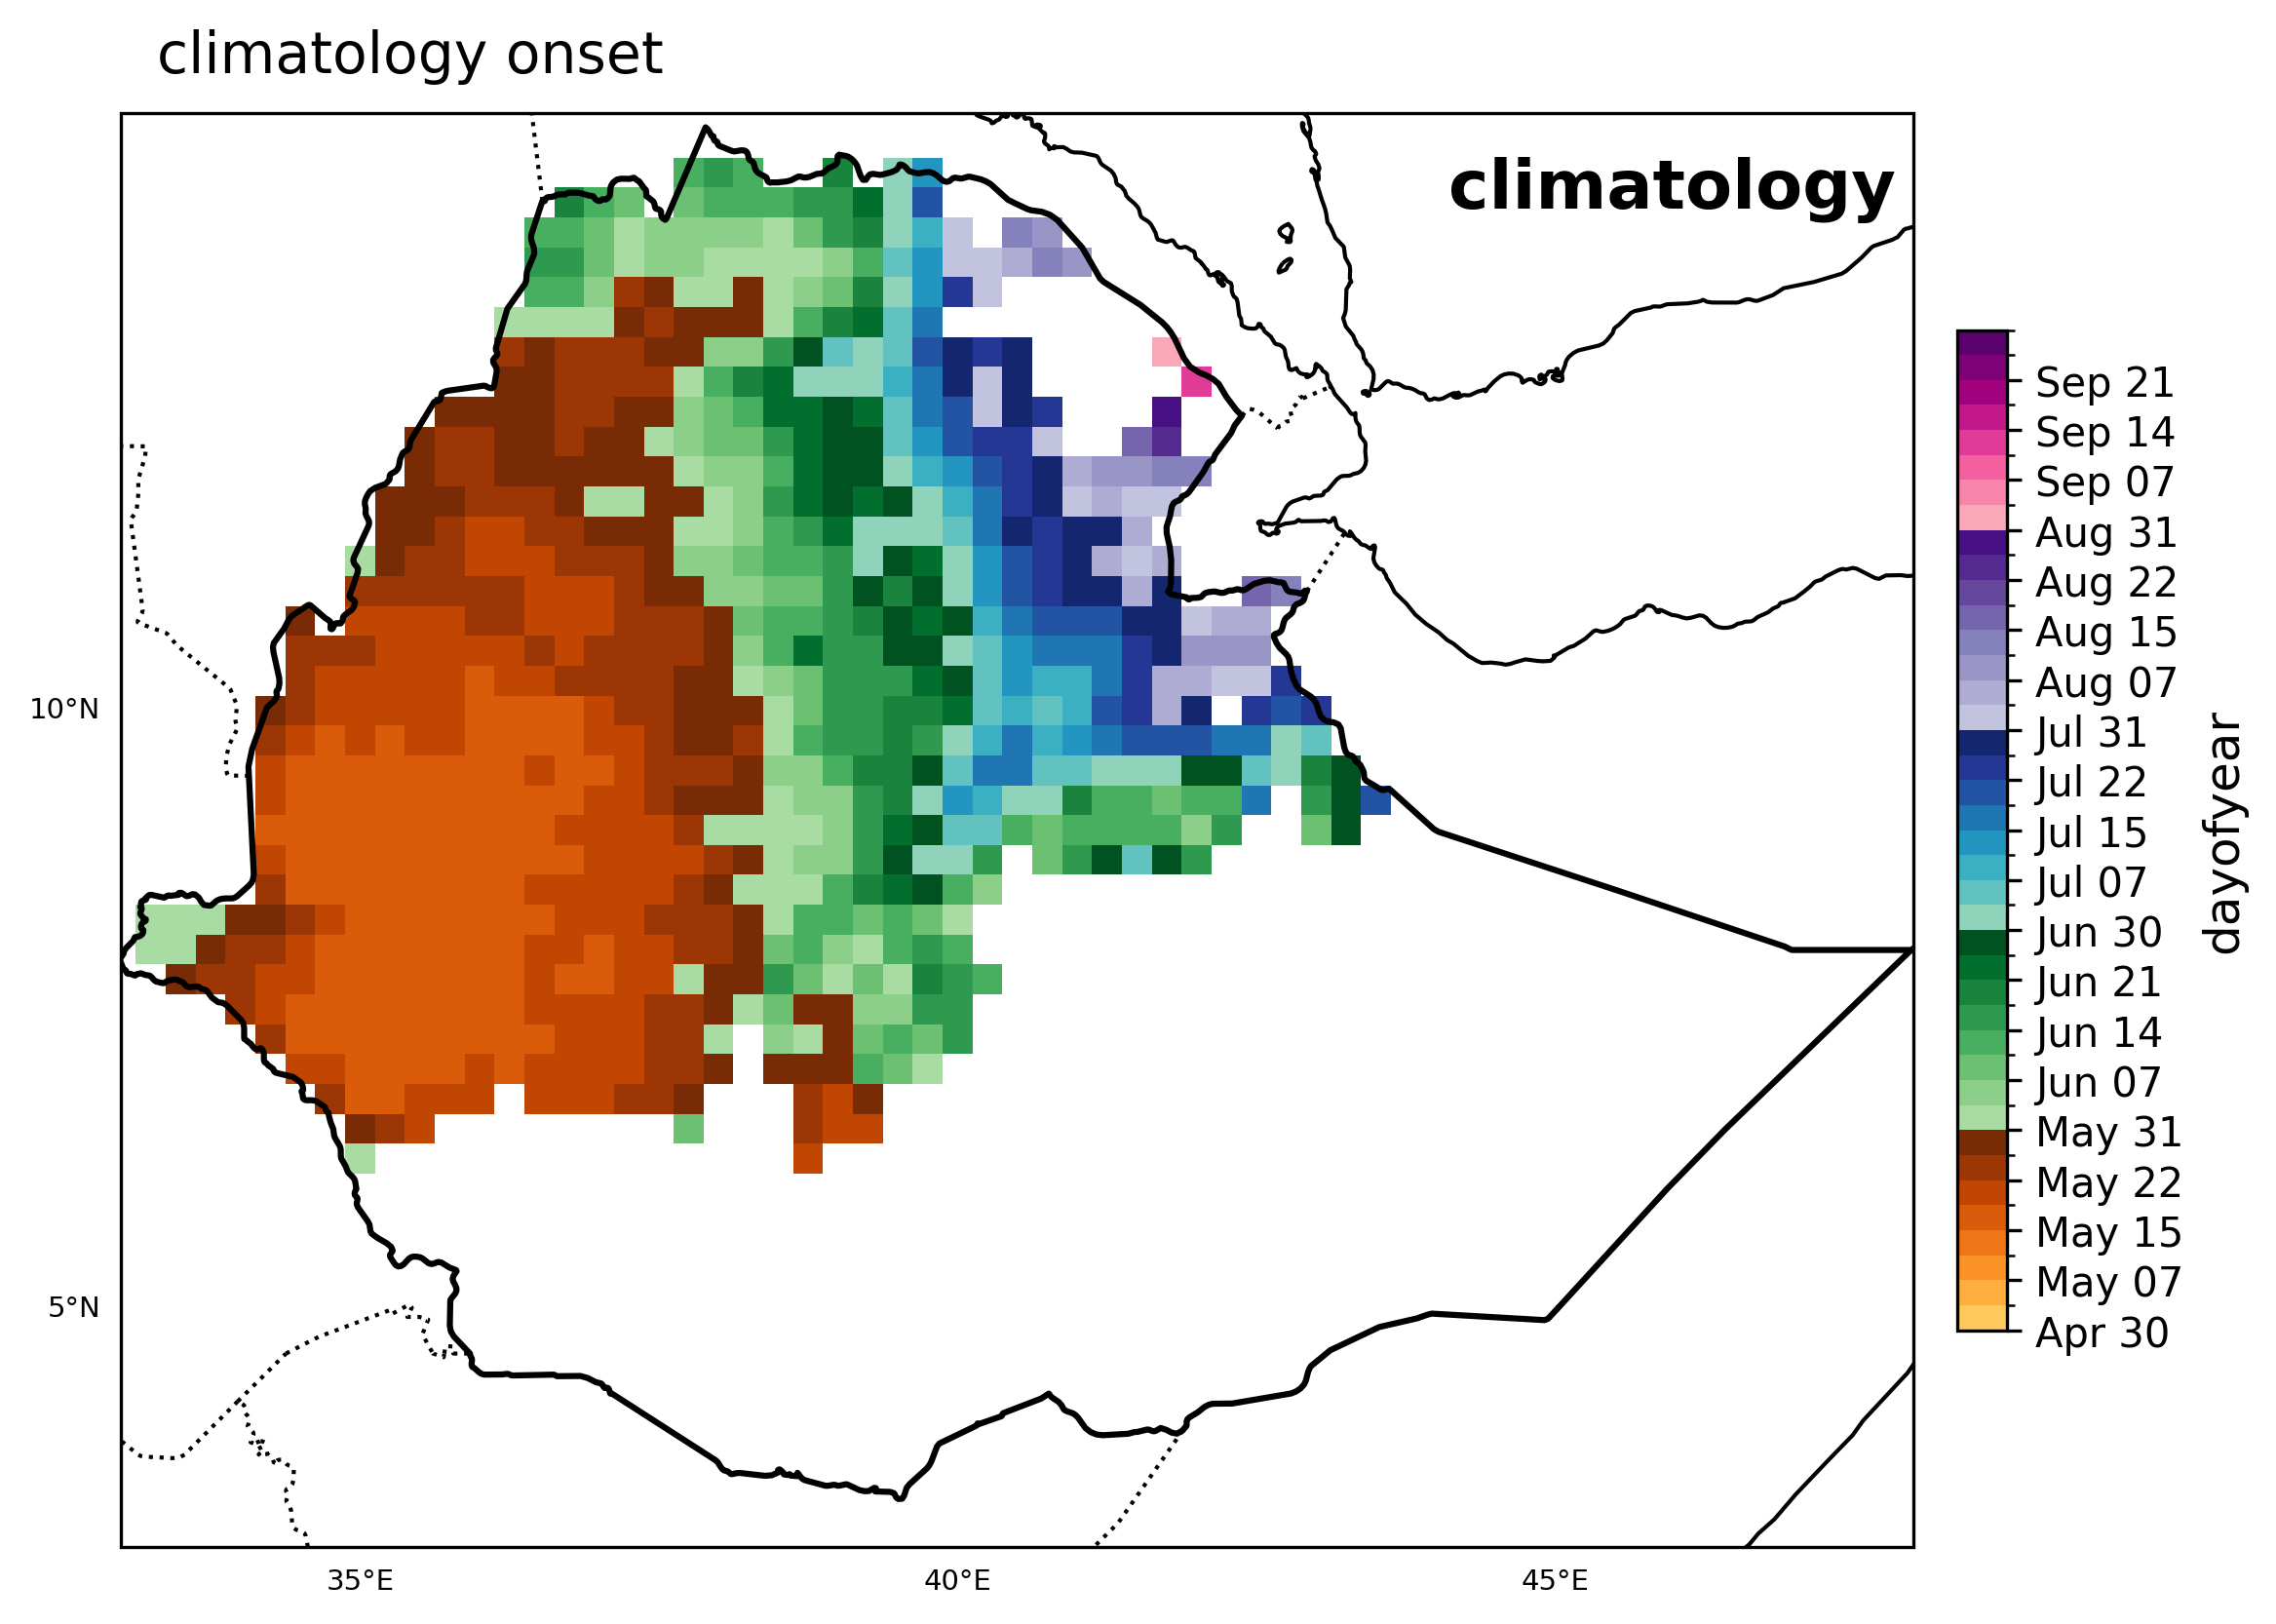

In [5]:
import os
start_year = cfg.start_year_clim
end_year = cfg.end_year_clim
dir_fig = cfg.dir_fig
fig_filename = os.path.join(dir_fig, f'climatology_onset_{str(start_year)}-{str(end_year)}.png')
display(Image(filename=fig_filename, width=690))

<br>

##### How does year 2000 compare to climatology in terms of onset day? 